In [ ]:
!unzip Abstract_gallery.zip

In [4]:
import os
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output
from PIL import Image

In [6]:
%matplotlib inline

path = '/content/Abstract_gallery/'
os.getcwd()
img_list = os.listdir(path)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid(x):
    return np.log(y/(1-y))

def access_images(img_list,path,length):
    
    pixels = []
    imgs = []
    
    for i in range(length):
        
        img = Image.open(path + img_list[i],'r')
        basewidth = 100
        img = img.resize((basewidth,basewidth), Image.ANTIALIAS)
        pix = np.array(img.getdata())
        pixels.append(pix.reshape(100,100,3))
        imgs.append(img)
        
    return np.array(pixels),imgs


def show_image(pix_list):
    
    array = np.array(pix_list.reshape(100,100,3), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()
    
    
pixels,imgs = access_images(img_list,path,2500)
pixels.shape

(2500, 100, 100, 3)

In [37]:
def define_discriminator(in_shape = (100,100,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 25 * 25
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((25, 25, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7) , padding='same'))
    return model

def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [38]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=10):
    
    bat_per_epo = int(dataset.shape[0] / n_batch)
    
    print(dataset.shape[0])
    
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        for j in range(bat_per_epo):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

In [39]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
   
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    filename = 'GAN_model_%03d.h5' % (epoch + 1)
    
    g_model.save(filename)

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = load_model('generator_model_final.h5')  #define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)

In [27]:
filename = 'GAN_model_final.h5'
    
g_model.save(filename)

In [11]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
from matplotlib.pyplot import figure

In [12]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

<Figure size 864x864 with 0 Axes>

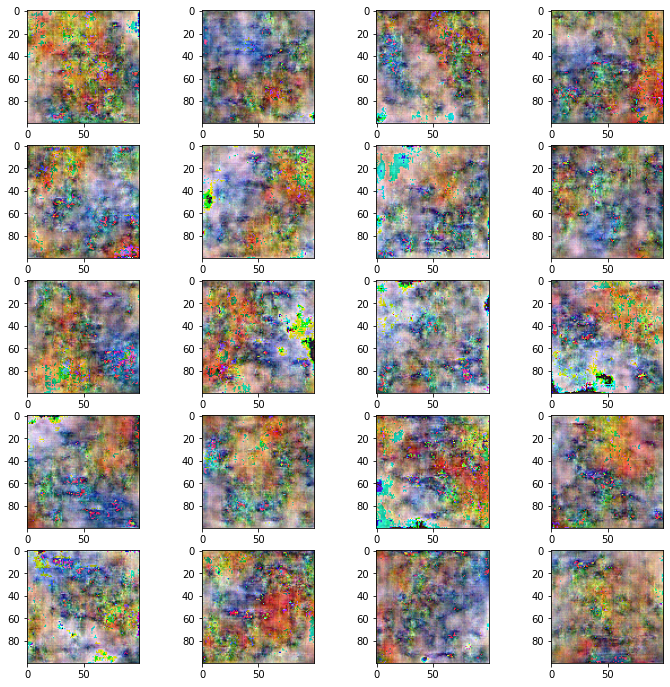

<Figure size 864x864 with 0 Axes>

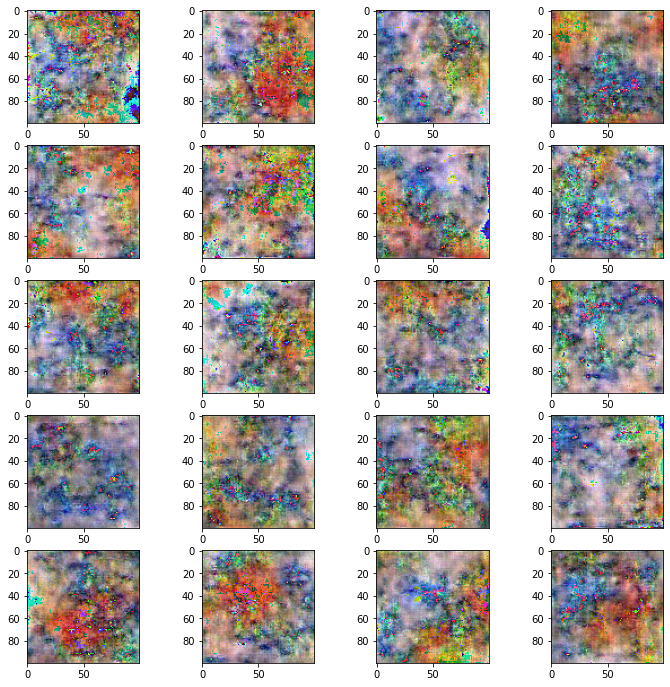

<Figure size 864x864 with 0 Axes>

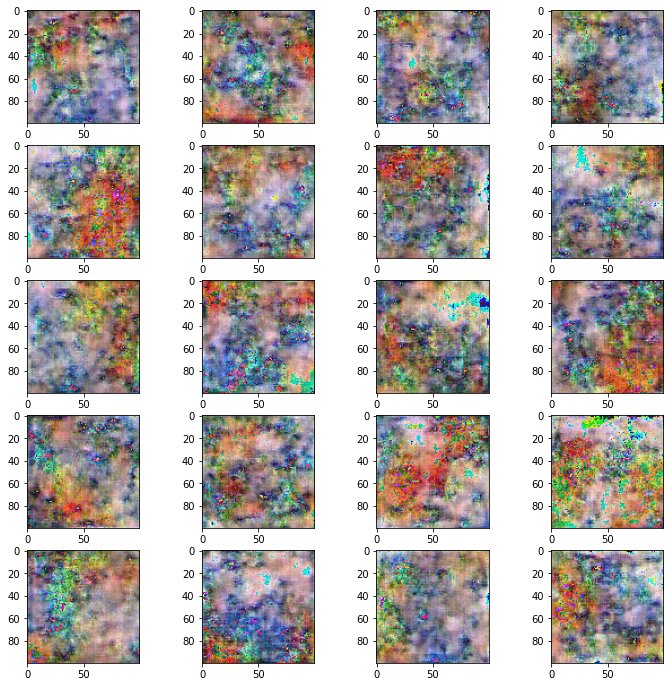

<Figure size 864x864 with 0 Axes>

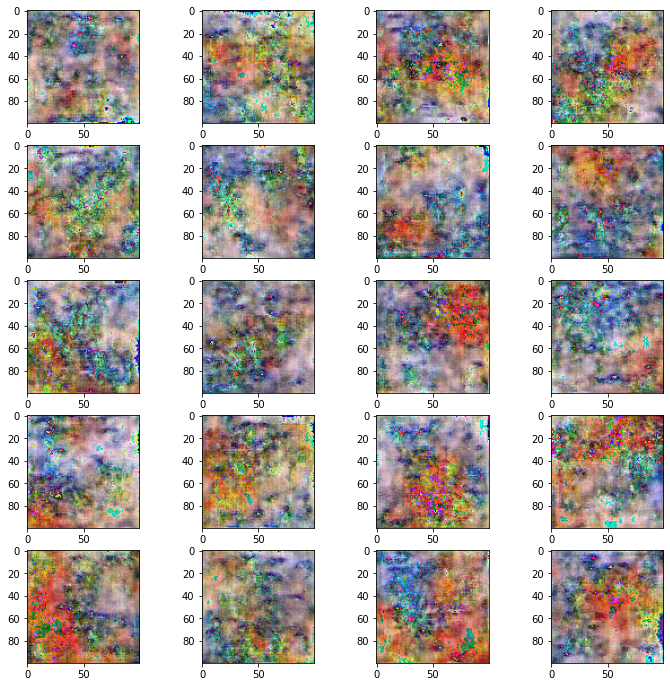

<Figure size 864x864 with 0 Axes>

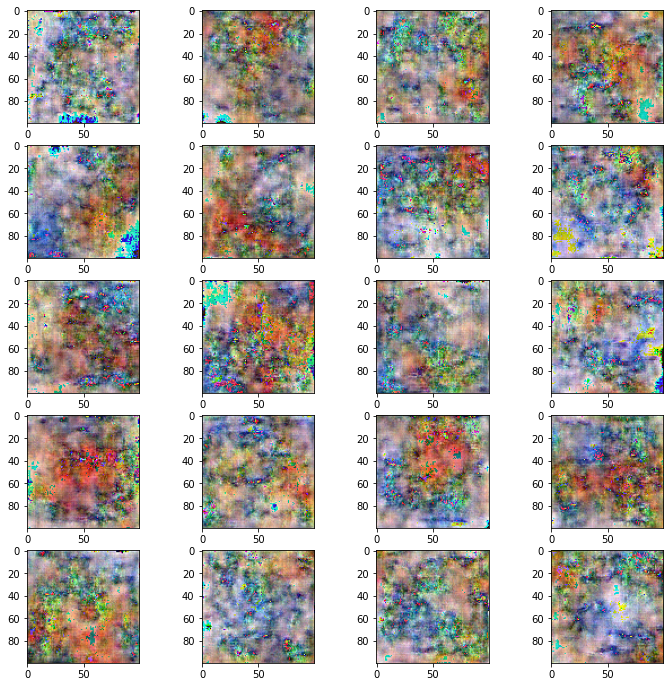

<Figure size 864x864 with 0 Axes>

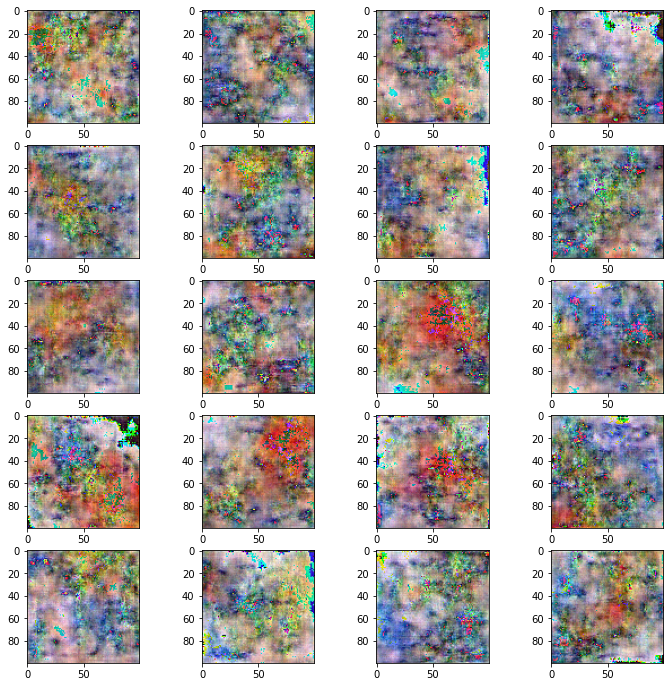

<Figure size 864x864 with 0 Axes>

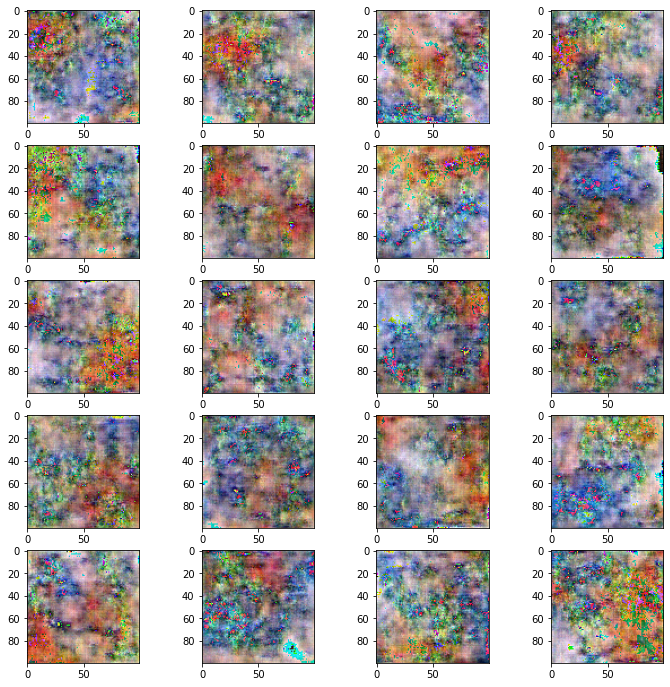

<Figure size 864x864 with 0 Axes>

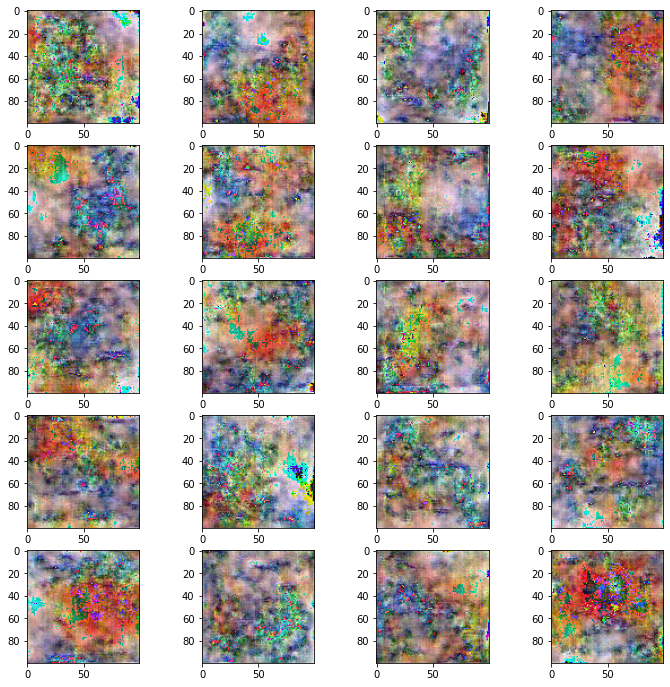

<Figure size 864x864 with 0 Axes>

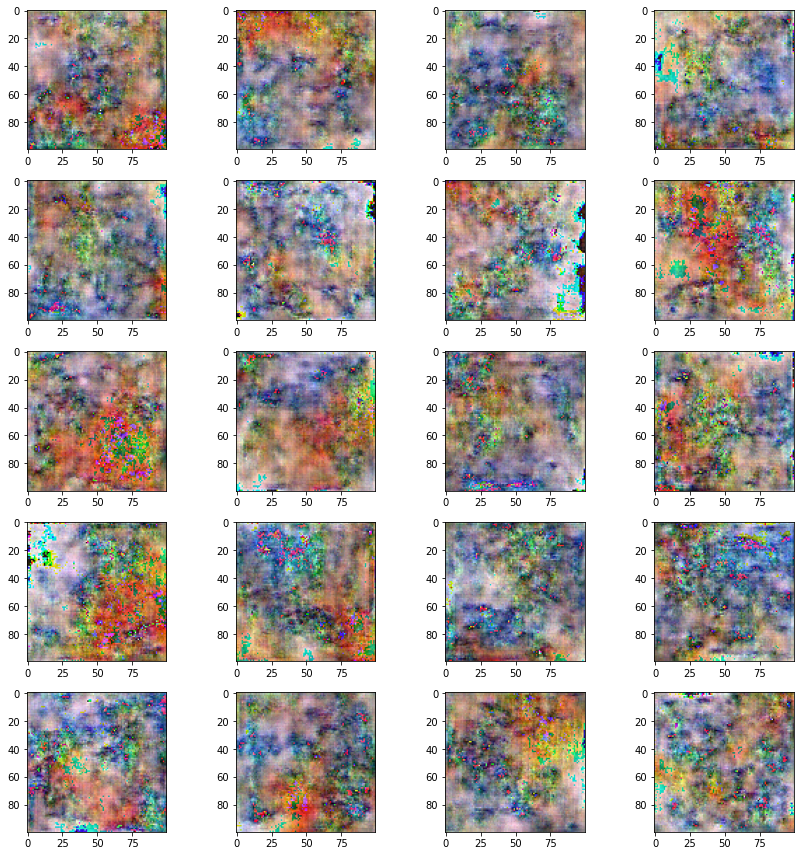

In [43]:

for y in range(1, 10):

    ind = y * 10
    if y < 10: ind = '0' + str(ind)

    model = load_model('GAN_model_' + str(ind) + '.h5')

    pyplot.figure(figsize=(12, 12))

    model = load_model('generator_model_final.h5')
    pyplot.figure(figsize=(12, 12))

    for x in range(0,20):
        
        pyplot.subplot(5, 4, x+1)

        latent_points = generate_latent_points(100,1)
        X = model.predict(latent_points)
        array = np.array(X.reshape(100,100,3), dtype=np.uint8)

        new_image = Image.fromarray(array)
        new_image.show()

        #print('Model ' + str(ind))
        pyplot.imshow(new_image)
    
pyplot.tight_layout()
pyplot.show()